In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
from typing import List, Tuple

# Load a pretrained YOLO11n model
model_path = 'runs/segment/train/weights/last.pt'


In [2]:
CLASSES = {'un-classified': '4', 'destroyed': '3', 'major-damage': '2', 'minor-damage': '1', 'no-damage': '0'}
CLASS_COLORS = {
    'un-classified': (93, 41, 84), 
    'destroyed': (95, 51, 131), 
    'major-damage': (111, 72, 188), 
    'minor-damage': (255, 107, 128), 
    'no-damage': (255, 163, 144)}

In [3]:
model = YOLO(model_path)

In [31]:
STEP = 'test'
# combined post processed images
COMBINED_IMG_PATH = f'resources/data/images/{STEP}/'
COMBINED_LABEL_PATH = f'resources/data/labels/{STEP}/'
# original path to images and labels
ORIGINAL_IMG_PATH = f'resources/{STEP}/images/'
ORIGINAL_LABEL_PATH = f'resources/{STEP}/labels/'
# list of combined images
combined_images = sorted(os.listdir(COMBINED_IMG_PATH))


def plot_bboxes(img: np.ndarray, results: list, mask: bool = 'colors') -> Tuple[np.ndarray]:
    """Generate annotation and mask images.

    Args:
        img (np.ndarray): 1024x1024 img to draw in.
        results (list): list of results of predictions of model.
        mask (bool, optional): if white mask must be draw in colors. Defaults to 'colors'.

    Returns:
        Tuple[np.ndarray]: Annotation and mask images.
    """
    black_background_img = np.zeros((1024, 1024, 3), dtype=np.uint8)
    names = results[0].names # class names dict
    scores = results[0].boxes.conf.numpy() # probabilities
    classes = results[0].boxes.cls.numpy() # predicted classes
    boxes = results[0].boxes.xyxy.numpy().astype(np.int32) # bboxes
    for score, cls, bbox in zip(scores, classes, boxes): # loop over all bboxes

        class_label = names[cls] # class name
        color = CLASS_COLORS[class_label]
        label = f"{class_label} : {score:0.2f}" # bbox label
        lbl_margin = 3 #label margin
        img = cv2.rectangle(img, (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            color=color,
                            thickness=2)
        label_size = cv2.getTextSize(label, # labelsize in pixels 
                                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                                     fontScale=1, thickness=1)
        lbl_w, lbl_h = label_size[0] # label w and h
        lbl_w += 2* lbl_margin # add margins on both sides
        lbl_h += 2*lbl_margin
        img = cv2.rectangle(img, (bbox[0], bbox[1]), # plot label background
                             (bbox[0]+lbl_w, bbox[1]-lbl_h),
                             color=color, 
                             thickness=-1) # thickness=-1 means filled rectangle
        cv2.putText(img, label, (bbox[0]+ lbl_margin, bbox[1]-lbl_margin), # write label to the image
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.0, color=(0, 0, 0),
                    thickness=3)
        
        # generate mask:
        black_background_img = cv2.rectangle(black_background_img, (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            color=color if mask == 'colors' else (255, 255, 255), 
                            thickness=-1)
    return img, black_background_img


In [ ]:
combined_img_name = combined_images[131]


def generate_prediction(combined_img_name: str):
    """Plot annotation image over image.

    Args:
        combined_img_name (str): name of combined image to generate predictions.
    """
    combined_path = COMBINED_IMG_PATH + combined_img_name
    post_img_name = combined_img_name.replace('combined', 'post')

    combined_img = cv2.imread(combined_path)
    post_image = cv2.imread(ORIGINAL_IMG_PATH+post_img_name)

    results = model(combined_img)

    img, mask = plot_bboxes(post_image, results, mask='colors')
    cv2.imshow('img', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

generate_prediction(combined_img_name)



0: 1056x1056 31 no-damages, 224.3ms
Speed: 5.6ms preprocess, 224.3ms inference, 31.9ms postprocess per image at shape (1, 3, 1056, 1056)


In [28]:
def generate_predictions_and_mask(s_folder: str = 'processed_data/test/'):
    """Generates annotation and mask images for test dataset images.

    Args:
        s_folder (str, optional): folder to save prediction results. Defaults to 'processed_data/test/'.
    """
    combined_images = sorted(os.listdir(COMBINED_IMG_PATH))
    for combined_img_name in combined_images:
        image_path = COMBINED_IMG_PATH + combined_img_name

        post_img_name = combined_img_name.replace('combined', 'post')

        original_image = cv2.imread(ORIGINAL_IMG_PATH+post_img_name)

        img = cv2.imread(image_path)
        results = model(img)
        
        img, mask = plot_bboxes(original_image, results, mask='white')
        s_folder_mask = s_folder+'masks/'
        s_folder_seg = s_folder+'segmentation/'
        if not os.path.exists(s_folder_mask):
            os.makedirs(s_folder_mask)
        if not os.path.exists(s_folder_seg):
            os.makedirs(s_folder_seg)
        cv2.imwrite(s_folder_mask+post_img_name, mask)
        cv2.imwrite(s_folder_seg+post_img_name, img)
    
generate_predictions_and_mask()


0: 1056x1056 1 no-damage, 219.8ms
Speed: 8.3ms preprocess, 219.8ms inference, 2.9ms postprocess per image at shape (1, 3, 1056, 1056)

0: 1056x1056 (no detections), 164.5ms
Speed: 3.6ms preprocess, 164.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1056, 1056)

0: 1056x1056 3 no-damages, 184.9ms
Speed: 4.5ms preprocess, 184.9ms inference, 3.6ms postprocess per image at shape (1, 3, 1056, 1056)

0: 1056x1056 (no detections), 156.3ms
Speed: 3.4ms preprocess, 156.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1056, 1056)

0: 1056x1056 12 no-damages, 2 major-damages, 168.9ms
Speed: 4.1ms preprocess, 168.9ms inference, 12.7ms postprocess per image at shape (1, 3, 1056, 1056)

0: 1056x1056 60 no-damages, 8 major-damages, 189.6ms
Speed: 3.5ms preprocess, 189.6ms inference, 87.7ms postprocess per image at shape (1, 3, 1056, 1056)

0: 1056x1056 65 no-damages, 162.7ms
Speed: 4.0ms preprocess, 162.7ms inference, 84.4ms postprocess per image at shape (1, 3, 1056, 1056)

0:

In [ ]:
# polygons = []
# final = ""
# #with open('prueba.txt', 'w') as f:
# for result in results:
#     boxes = result.boxes.xyxy.numpy()
#     for box in boxes:
#         x0 = float(box[0])
#         y0 = float(box[1])

#         x1 = float(box[2])
#         y1 = float(box[3])
#         polygons.append(np.array([[x0, y0], [x1, y0], [x1,y1], [x0, y1]], np.int32))
#         #polygons.append(box)
#         #polygons.append(box.astype(np.int32).reshape((2,2)))

# # for _e in d['features']['xy']:
# #     st_p = classes[_e['properties']['subtype']]
# #     pairs = [coords for coords in _e['wkt'][10:-2].split(", ")]
# #     nd_p = ""
# #     coordinates = []
# #     for pair in pairs:
# #         x, y = pair.split(" ")
# #         x = round(float(x), 4)
# #         y = round(float(y), 4)
# #         coordinates.append([x,y])
# #         nd_p += " " + str(x/1024) + " " + str(y/1024)
# #     final = st_p + nd_p
# #     polygons.append(np.array(coordinates, dtype=int))
# #     print(final)
# print(len(polygons))
# polygons[0].shape

193


(4, 2)

In [ ]:
# original_path = 'resources/test/images/'
# img2 = cv2.imread(original_path+post_img_name)
# #n_in_ = cv2.polylines(img2, pts=polygons, isClosed=True, color=(0,255,0), thickness=4, lineType=16)
# # cv2.imshow('prueba', n_in_)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

In [ ]:
import random
import numpy as np

colors = [random.choices(range(256), k=3) for _ in [0,1,2,3,4]]

for result in results:
    for mask, box in zip(result.masks.xy, result.boxes):
        points = np.int32([mask])
        color_number = [0,1,2,3,4].index(int(box.cls[0]))
        img2 = cv2.fillPoly(img, points, colors[color_number])


0: 1056x1056 5 destroyeds, 242.9ms
Speed: 11.3ms preprocess, 242.9ms inference, 5.2ms postprocess per image at shape (1, 3, 1056, 1056)
resources/data/labels/test/hurricane-matthew_00000114_combined_disaster.txt

0: 1056x1056 1 no-damage, 3 major-damages, 184.2ms
Speed: 4.1ms preprocess, 184.2ms inference, 5.1ms postprocess per image at shape (1, 3, 1056, 1056)
resources/data/labels/test/hurricane-florence_00000186_combined_disaster.txt

0: 1056x1056 16 no-damages, 1 major-damage, 197.3ms
Speed: 4.1ms preprocess, 197.3ms inference, 24.7ms postprocess per image at shape (1, 3, 1056, 1056)
resources/data/labels/test/hurricane-florence_00000262_combined_disaster.txt

0: 1056x1056 1 no-damage, 97 minor-damages, 219.1ms
Speed: 6.6ms preprocess, 219.1ms inference, 131.5ms postprocess per image at shape (1, 3, 1056, 1056)
resources/data/labels/test/hurricane-matthew_00000345_combined_disaster.txt

0: 1056x1056 132 no-damages, 76 major-damages, 176.0ms
Speed: 3.9ms preprocess, 176.0ms inferen

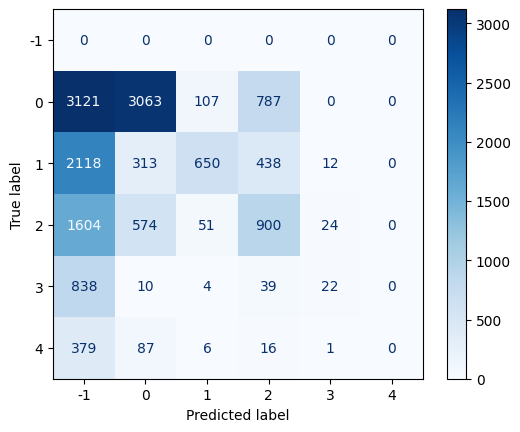

In [ ]:
def generate_rects(label_path: str, save: bool= False, file_path_ts:str='processed_data/test/', _generate_rects:bool = True) -> Tuple[List[List[int]], List[int]]:
    """Generate rectangle coordinates for each poligon in label.

    Args:
        label_path (str): path to label of test dataset.
        save (bool, optional): if transformed rects must be saved. Defaults to False.
        file_path_ts (str, optional): file path to save. Defaults to 'processed_data/test/'.
        _generate_rects (bool, optional): if rects must be generated. Defaults to True.

    Returns:
        Tuple[List[List[int]], List[int]]: _description_
    """
    if not _generate_rects:
        with open(f'{file_path_ts}predicted_rects.pkl', 'rb') as p_rcts:
            rects = pickle.load(p_rcts) # deserialize using load()

        with open(f'{file_path_ts}predicted_cls.pkl', 'rb') as p_cls:
            original_cls = pickle.load(p_cls)

    else:
        with open(label_path) as f:
            file = f.read()

        print(label_path)
        
        original_cls = [int(l[0]) for l in file.split('\n') if l]
        raw_nums = [[round(float(n), 4)*1024 for n in l[2:].split()] for l in file.split('\n') if l]
        txt = [[p for p in zip(row[::2], row[1::2])] for row in raw_nums]

        rects = []
        for line in txt:
            x0 = float('inf')
            y0 = float('inf')
            x1 = -1
            y1 = -1
            for pair in line:
                x = pair[0]
                y = pair[1]
                if x < x0:
                    x0 = x
                if y < y1:
                    y0 = y
                if x > x1:
                    x1 = x
                if y > y1:
                    y1 = y
            rects.append([x0, y0, x1, y1])

        if save:
            with open(file_path_ts+'predicted_rects.pkl', 'wb') as f:
                pickle.dump(rects, f)
            with open(file_path_ts+'predicted_cls.pkl', 'wb') as f:
                pickle.dump(original_cls, f)
        
        
    return rects, original_cls

def pair_boxes(results_: list, rects: List[List[int]], original_cls: List[int], threshold: int = 55) -> List[int]:
    """Generate a list of response classes paired with original ones.

    Args:
        results_ (list): lists of results of YOLO prediction.
        rects (List[List[int]]): list of rectangle coordinates.
        original_cls (List[int]): list of original classes.
        threshold (int, optional): threshold to pair original with response rectangle. Defaults to 55.

    Returns:
        List[int]: list of response classes.
    """
    response_cls = [-1 for _ in original_cls]
    classes = results_[0].boxes.cls.numpy().tolist() # predicted classes
    boxes = results_[0].boxes.xyxy.numpy().astype(np.int32).tolist() # bboxes
    for i, o_rect in enumerate(rects):
        min_distance = float('inf')
        _del = -1
        for j, (bbox, cls) in enumerate(zip(boxes, classes)): # loop over all bboxes
            distance = abs(o_rect[0] - bbox[0])
            distance += abs(o_rect[1] - bbox[1])
            distance += abs(o_rect[2] - bbox[2])
            distance += abs(o_rect[3] - bbox[3])

            if distance < min_distance and distance < threshold:
                # print(distance)
                response_cls[i] = int(cls)
                _del = j
        if len(boxes) > 0 and _del != -1:
            boxes.pop(_del)
            classes.pop(_del)

    return response_cls
    

def generate_confusion_matrix(_generate_rects:bool=True, path_to_sd ='processed_data/test/'):
    """Generates confusion matrix.

    Args:
        _generate_rects (bool, optional): if generate rectangles or load from saved file. Defaults to True.
        path_to_sd (str, optional): path to saved_. Defaults to 'processed_data/test/'.
    """
    final_response_cls = []
    final_original_cls = []
    for img_name in os.listdir(COMBINED_IMG_PATH):
        img_name = img_name.replace('.png', '')
        img_ = cv2.imread(f'{COMBINED_IMG_PATH}{img_name}.png')
        label_path = f'{COMBINED_LABEL_PATH}{img_name}.txt'

        results_ = model(img_)
        
        rects, original_cls = generate_rects(label_path, save=True, file_path_ts=path_to_sd, _generate_rects = _generate_rects)

        response_cls = pair_boxes(results_, rects, original_cls)

        final_original_cls += original_cls
        final_response_cls += response_cls

    cm = confusion_matrix(final_original_cls, final_response_cls)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[-1,0,1,2,3,4],)
    {'un-classified': '4', 'destroyed': '3', 'major-damage': '2', 'minor-damage': '1', 'no-damage': '0
    disp.plot(cmap="Blues")


generate_confusion_matrix()

In [ ]:

# response_cls = [-1 for _ in original_cls]
# threshold = 55

# classes = results_[0].boxes.cls.numpy().tolist() # predicted classes
# boxes = results_[0].boxes.xyxy.numpy().astype(np.int32).tolist() # bboxes
# for i, o_rect in enumerate(rects):
#     min_distance = float('inf')
#     # print(f'min_distance: {min_distance}')
#     _del = -1
#     for j, (bbox, cls) in enumerate(zip(boxes, classes)): # loop over all bboxes
#         distance = abs(o_rect[0] - bbox[0])
#         distance += abs(o_rect[1] - bbox[1])
#         distance += abs(o_rect[2] - bbox[2])
#         distance += abs(o_rect[3] - bbox[3])
#         # print(cls)
    
#         # print(f'distance: {distance}')
#         if distance < min_distance and distance < threshold:
#             # print(distance)
#             response_cls[i] = int(cls)
#             _del = j
#     if len(boxes) > 0 and _del != -1:
#         boxes.pop(_del)
#         classes.pop(_del)

min_distance: inf
0.0
distance: 3262.9584
0.0
distance: 1421.9584
2.0
distance: 633.9584000000001
0.0
distance: 1599.9584
2.0
distance: 683.5648000000001
0.0
distance: 1216.9584
0.0
distance: 214.95840000000004
0.0
distance: 3469.9584
0.0
distance: 1389.9584
0.0
distance: 3068.9584
2.0
distance: 656.9584
0.0
distance: 1722.9584
0.0
distance: 2061.9584
0.0
distance: 2974.9584
2.0
distance: 1155.9584
2.0
distance: 846.9584000000001
2.0
distance: 1121.9584
0.0
distance: 3525.9584
0.0
distance: 256.95840000000004
2.0
distance: 2953.9584
2.0
distance: 3267.9584
2.0
distance: 469.95840000000004
0.0
distance: 3212.9584
2.0
distance: 3523.9584
2.0
distance: 924.9584000000001
0.0
distance: 2957.9584
0.0
distance: 32.81279999999998
32.81279999999998
0.0
distance: 3253.9584
2.0
distance: 1476.9584
0.0
distance: 1753.9584
0.0
distance: 3603.9584
2.0
distance: 1205.9584
0.0
distance: 1494.9584
0.0
distance: 3270.9584
0.0
distance: 1861.9584
0.0
distance: 924.9584000000001
2.0
distance: 1941.9584
0.